In [23]:
# install
!pip install findspark
!pip install pyspark
import findspark
findspark.init()

In [24]:
# init
import findspark
findspark.init()

# Import necessary libraries
from pyspark.sql import SparkSession
from pyspark.ml.feature import Tokenizer, StopWordsRemover, HashingTF, IDF, StandardScaler, Word2Vec
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.sql.functions import col
from pyspark.sql.functions import length
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Start Spark session
spark = SparkSession.builder.appName("Amazon Fine Food Reviews Classification").getOrCreate()

# Load dataset
df = spark.read.csv('/kaggle/input/amazon-fine-food-reviews/Reviews.csv', header=True, inferSchema=True)

df.show(10)

+---+----------+--------------+--------------------+--------------------+----------------------+-----+----------+--------------------+--------------------+
| Id| ProductId|        UserId|         ProfileName|HelpfulnessNumerator|HelpfulnessDenominator|Score|      Time|             Summary|                Text|
+---+----------+--------------+--------------------+--------------------+----------------------+-----+----------+--------------------+--------------------+
|  1|B001E4KFG0|A3SGXH7AUHU8GW|          delmartian|                   1|                     1|    5|1303862400|Good Quality Dog ...|I have bought sev...|
|  2|B00813GRG4|A1D87F6ZCVE5NK|              dll pa|                   0|                     0|    1|1346976000|   Not as Advertised|"Product arrived ...|
|  3|B000LQOCH0| ABXLMWJIXXAIN|"Natalia Corres "...|                   1|                     1|    4|1219017600|"""Delight"" says...|"This is a confec...|
|  4|B000UA0QIQ|A395BORC6FGVXV|                Karl|            

In [25]:
# Drop rows with missing values
df = df.dropna()

# Create a new label column: convert rating to binary classification (positive or negative)
df = df.withColumn("label", (df.Score > 3).cast("integer"))  # Label as 1 for positive and 0 for negative

# Filter out null or invalid label values
df = df.filter(df['label'].isNotNull())
df = df.filter((df['label'] == 0) | (df['label'] == 1))

# Feature Engineering: Add review length and helpfulness score
df = df.withColumn("review_length", length(col("Text")))
df = df.withColumn("helpfulness_score", df.HelpfulnessNumerator / df.HelpfulnessDenominator)
df = df.fillna({"helpfulness_score": 0.0})  # Fill NaN values with 0

# Split the data into train and test sets
train_data, test_data = df.randomSplit([0.8, 0.2], seed=1234)

# Oversample the minority class (label 0)
major_df = train_data.filter(train_data.label == 1)
minor_df = train_data.filter(train_data.label == 0)
ratio = major_df.count() / minor_df.count()
oversampled_minor_df = minor_df.sample(withReplacement=True, fraction=ratio)
train_data = major_df.unionAll(oversampled_minor_df)


In [27]:
# Split the data into train and test sets
train_data, test_data = df.randomSplit([0.8, 0.2], seed=1234)
# The Score column (which contains ratings from 1 to 5) is converted into a binary label:

# 1 for scores greater than 3 (positive reviews)
# 0 for scores less than or equal to 3 (negative reviews)

# Tokenize the reviews
tokenizer = Tokenizer(inputCol="Text", outputCol="words")

# Remove stop words
remover = StopWordsRemover(inputCol="words", outputCol="filtered")

# Convert text into word embeddings using Word2Vec
word2vec = Word2Vec(inputCol="filtered", outputCol="wordEmbeddings", vectorSize=100, minCount=5)

# Scale the features
scaler = StandardScaler(inputCol="wordEmbeddings", outputCol="scaledFeatures")

# Initialize RandomForest classifier
rf = RandomForestClassifier(featuresCol="scaledFeatures", labelCol="label", numTrees=50)

# Build pipeline
pipeline = Pipeline(stages=[tokenizer, remover, word2vec, scaler, rf])

# Fit the model on the training data
model = pipeline.fit(train_data)

# Make predictions on the test data
predictions = model.transform(test_data)

# Evaluate the model
evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(predictions)
print(f"Test Accuracy: {accuracy}")



24/10/22 02:48:39 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS
24/10/22 03:05:58 WARN MemoryStore: Not enough space to cache rdd_309_0 in memory! (computed 61.1 MiB so far)
24/10/22 03:05:58 WARN BlockManager: Persisting block rdd_309_0 to disk instead.
24/10/22 03:05:58 WARN MemoryStore: Not enough space to cache rdd_309_1 in memory! (computed 61.1 MiB so far)
24/10/22 03:05:58 WARN BlockManager: Persisting block rdd_309_1 to disk instead.


Test Accuracy: 0.7806375255036698


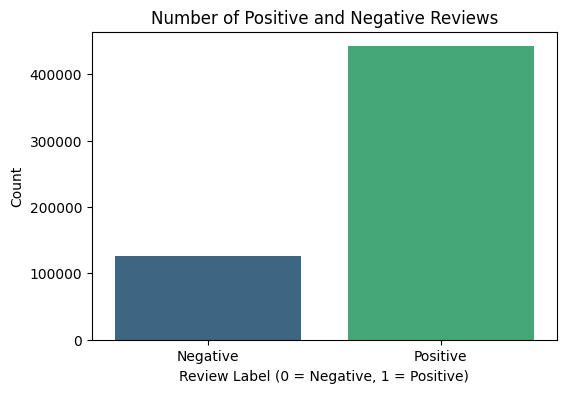

In [28]:
# Convert the Spark DataFrame to a Pandas DataFrame for easier plotting
df_pandas = df.select('label').toPandas()

# Count the number of positive and negative reviews
review_counts = df_pandas['label'].value_counts()

# Plot the data
plt.figure(figsize=(6,4))
sns.barplot(x=review_counts.index, y=review_counts.values, palette="viridis")
plt.title('Number of Positive and Negative Reviews')
plt.xlabel('Review Label (0 = Negative, 1 = Positive)')
plt.ylabel('Count')
plt.xticks([0, 1], ['Negative', 'Positive'])
plt.show()

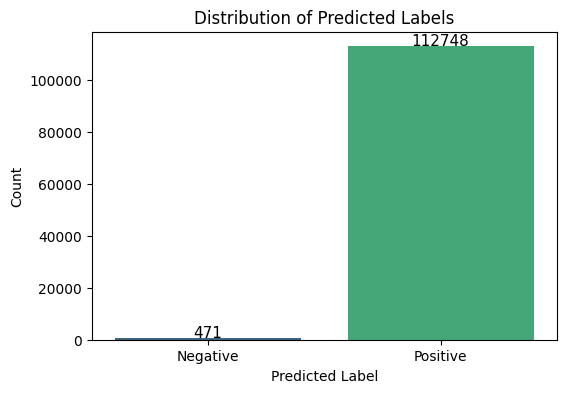

In [31]:
# Plot the distribution of predictions
plt.figure(figsize=(6,4))
ax = sns.barplot(x='prediction', y='count', data=pred_label_dist, palette="viridis")

# Add exact numbers on top of each bar
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}', 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha = 'center', va = 'baseline', 
                fontsize=11, color='black', xytext=(0, 1), 
                textcoords='offset points')

plt.title('Distribution of Predicted Labels')
plt.xlabel('Predicted Label')
plt.ylabel('Count')
plt.xticks([0, 1], ['Negative', 'Positive'])
plt.show()

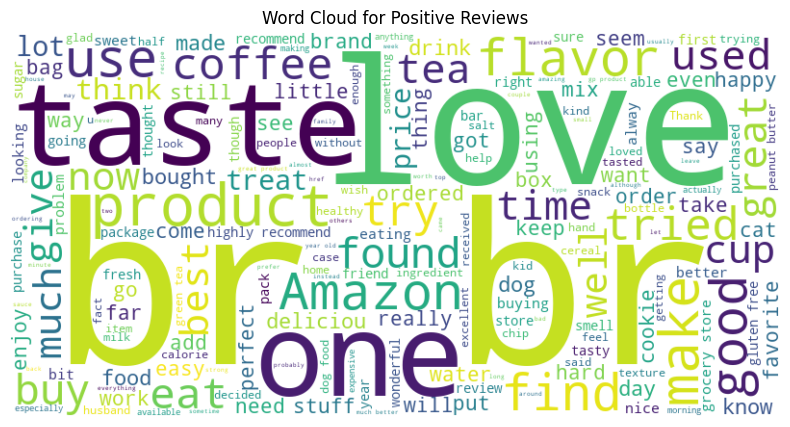

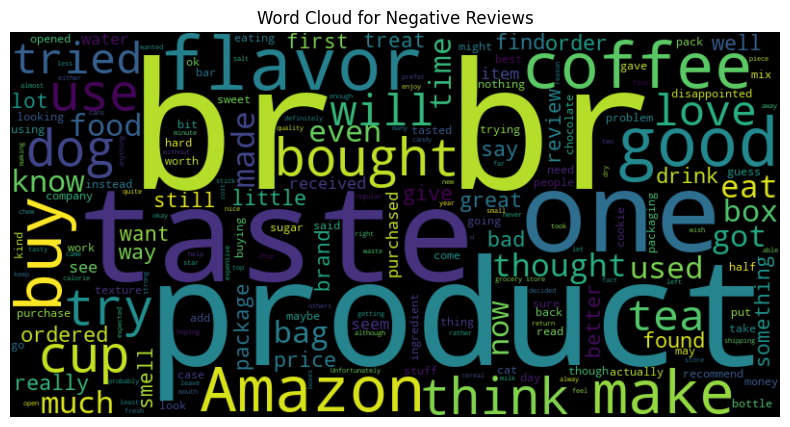

In [30]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Convert positive and negative reviews to a single string
positive_reviews = " ".join(df.filter(df['label'] == 1).select("Text").rdd.flatMap(lambda x: x).collect())
negative_reviews = " ".join(df.filter(df['label'] == 0).select("Text").rdd.flatMap(lambda x: x).collect())

# Generate word clouds
positive_wordcloud = WordCloud(width=800, height=400, background_color='white').generate(positive_reviews)
negative_wordcloud = WordCloud(width=800, height=400, background_color='black').generate(negative_reviews)

# Plot the word clouds for positive reviews
plt.figure(figsize=(10, 5))
plt.imshow(positive_wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud for Positive Reviews')
plt.show()

# Plot the word clouds for negative reviews
plt.figure(figsize=(10, 5))
plt.imshow(negative_wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud for Negative Reviews')
plt.show()
